# Generating Google Trend Sentiment Data

### Import Packages and load file

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

### Original Google Data (2010-01-01 ~ 2018-12-31) for Visualization

In [2]:
google_df = pd.read_csv("../final_data_0518/google_trend_2019-2022.csv")
google_df['date'] = pd.to_datetime(google_df['date'].astype("string")).dt.to_period('d')
google_df = google_df.set_index('date').to_timestamp()
google_df.columns = ['google_1', 'google_2', 'google_3', 'google_4', 'google_5', 'google_6']

[Text(0.5, 1.0, 'Daily Google Search volume for Dow Jones')]

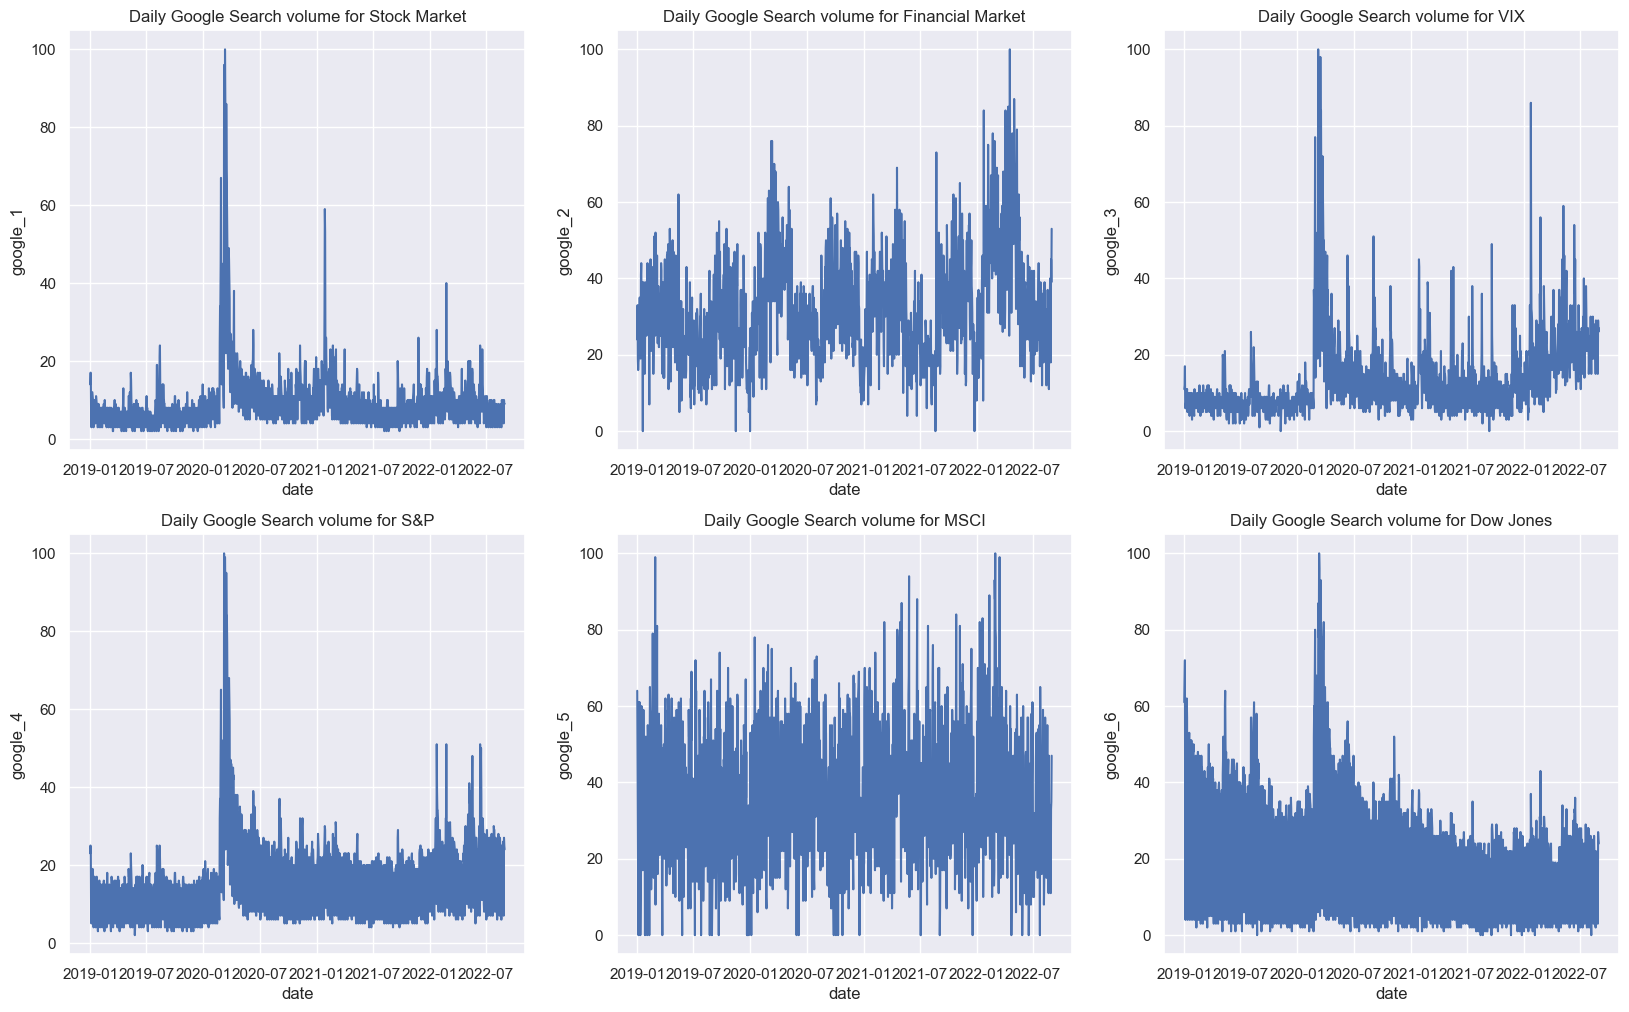

In [9]:
# Plot Google Search Volume

fig, axs = plt.subplots(ncols=3, nrows=2)
plt.gcf().set_size_inches(20, 12)
sns.lineplot(x=google_df.index, y='google_1', data=google_df, ax=axs[0,0]).set(title="Daily Google Search volume for Stock Market")
sns.lineplot(x=google_df.index, y='google_2', data=google_df, ax=axs[0,1]).set(title="Daily Google Search volume for Financial Market")
sns.lineplot(x=google_df.index, y='google_3', data=google_df, ax=axs[0,2]).set(title="Daily Google Search volume for VIX")
sns.lineplot(x=google_df.index, y='google_4', data=google_df, ax=axs[1,0]).set(title="Daily Google Search volume for S&P")
sns.lineplot(x=google_df.index, y='google_5', data=google_df, ax=axs[1,1]).set(title="Daily Google Search volume for MSCI")
sns.lineplot(x=google_df.index, y='google_6', data=google_df, ax=axs[1,2]).set(title="Daily Google Search volume for Dow Jones")

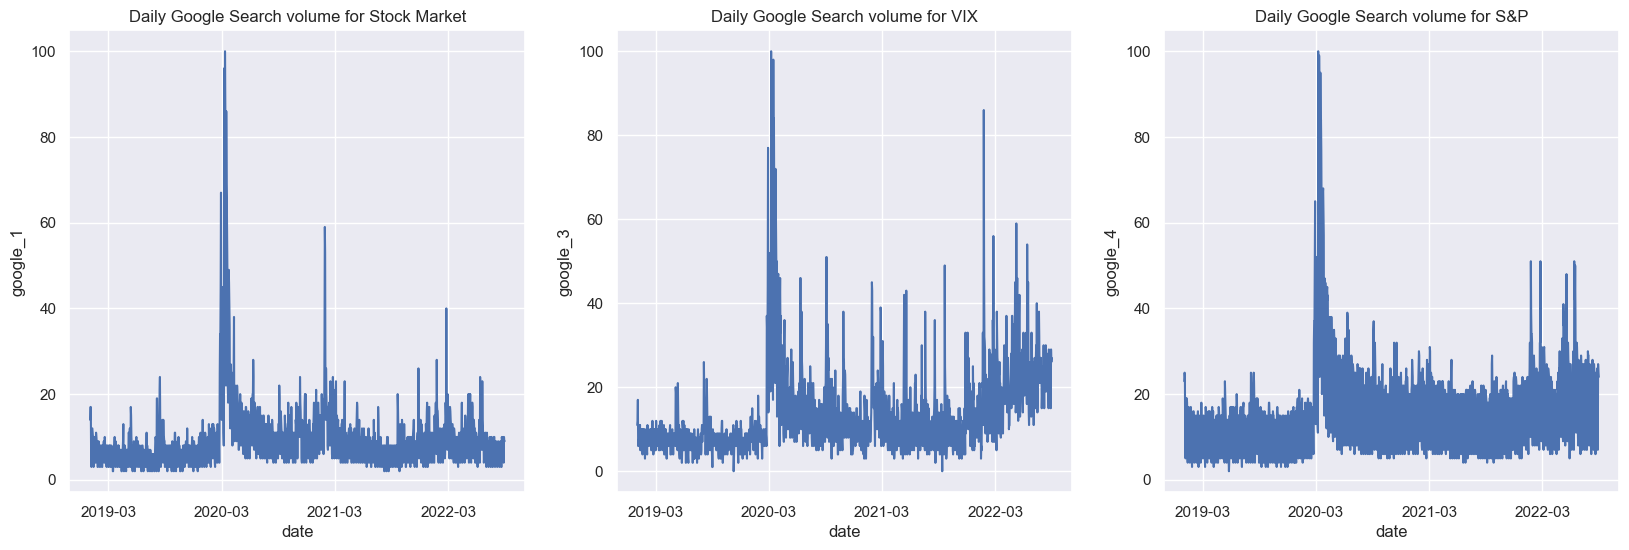

In [13]:
google_df_show = google_df[['google_1','google_3','google_4']]

fig, axs = plt.subplots(ncols=3)
plt.gcf().set_size_inches(20, 6)
sns.set(style='darkgrid')
sns.lineplot(x=google_df_show.index, y='google_1', data=google_df_show, ax=axs[0]).set(title="Daily Google Search volume for Stock Market")
sns.lineplot(x=google_df_show.index, y='google_3', data=google_df_show, ax=axs[1]).set(title="Daily Google Search volume for VIX")
sns.lineplot(x=google_df_show.index, y='google_4', data=google_df_show, ax=axs[2]).set(title="Daily Google Search volume for S&P")

for axs in axs :
    axs.xaxis.set_major_locator(md.MonthLocator(bymonth=3))


### Generating Google Dataframe

In [61]:
# Code here is from : 
# https://github.com/qztseng/google-trends-daily/blob/master/gtrend.py

from datetime import datetime, timedelta, date, time
import pandas as pd
import time

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError


def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, timeframe=timeframe, cat=cat, geo=geo, gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            time.sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=-300, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

In [62]:
# Set the dates that we want to get for google
pytrend = TrendReq()
start = '2019-01-01'
end = '2022-08-31'
geo='US'
cat=0
gprop=''

keyword_1 = "Stock Market"
keyword_2 = "Financial Market"
keyword_3 = "VIX"
keyword_4 = "S&P"
keyword_5 = "MSCI"
keyword_6 = "Dow Jones Industrial Average"

In [63]:
google_1 = get_daily_trend(keyword=keyword_1, start=start, end=end, trendreq=pytrend, geo=geo, cat=cat, gprop=gprop)
google_2 = get_daily_trend(keyword=keyword_2, start=start, end=end, trendreq=pytrend, geo=geo, cat=cat, gprop=gprop)
google_3 = get_daily_trend(keyword=keyword_3, start=start, end=end, trendreq=pytrend, geo=geo, cat=cat, gprop=gprop)
google_4 = get_daily_trend(keyword=keyword_4, start=start, end=end, trendreq=pytrend, geo=geo, cat=cat, gprop=gprop)
google_5 = get_daily_trend(keyword=keyword_5, start=start, end=end, trendreq=pytrend, geo=geo, cat=cat, gprop=gprop)
google_6 = get_daily_trend(keyword=keyword_6, start=start, end=end, trendreq=pytrend, geo=geo, cat=cat, gprop=gprop)

In [64]:
google_df = pd.concat([google_1['Stock Market'], google_2['Financial Market'], google_3['VIX'], google_4['S&P'], google_5['MSCI'], google_6['Dow Jones Industrial Average']], axis = 1)
google_df.head()

,Stock Market,Financial Market,VIX,S&P,MSCI,Dow Jones Industrial Average
date,,,,,,
2019-01-01 19:00:00,14.0,24.0,11.0,23.0,64.0,61.0
2019-01-02 19:00:00,17.0,33.0,12.0,25.0,45.0,67.0
2019-01-03 19:00:00,17.0,19.0,17.0,24.0,24.0,72.0
2019-01-04 19:00:00,6.0,16.0,6.0,7.0,12.0,10.0
2019-01-05 19:00:00,3.0,18.0,6.0,5.0,0.0,4.0
...,...,...,...,...,...,...
2022-08-26 19:00:00,5.0,24.0,27.0,8.0,19.0,5.0
2022-08-27 19:00:00,4.0,18.0,15.0,7.0,11.0,3.0
2022-08-28 19:00:00,10.0,45.0,29.0,27.0,33.0,27.0


In [67]:
# Save Data
# google_df.to_csv("../final_data_0518/google_trend_2019-2022.csv", index = True)